#### Lake level extraction by using swot_l2_hr_pixc data 
Processing workflow：   
(1) data reading;  
(2) geophysical correction and elevation reference conversion;    
(3) outliers removing;    
(4) time-series water level calculation.


In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from utils.functions import IQR_filter, pixc_geophy_cor
from utils.transform_time import dt64_to_dyr


In [2]:
dir_pixc = 'data/dianchi-lake/pixc'
path_dianchi_vec = 'data/dianchi-lake/dianchi_vector.gpkg'
path_img = 'data/rsimg/dianchi_s2_20200511_wgs84.tif'



#### (1) swot pixc data read and check

In [3]:
## Check original _readout.nc raster file.
paths_file = [os.path.join(dir_pixc, file) for file in os.listdir(dir_pixc) if 'masked' in file and '.nc' in file]
paths_file = sorted(paths_file, key=lambda x: x.split('/')[-1].split('_')[-5])
print(len(paths_file))
id = 1
path_file = paths_file[id]
print(path_file)
## read one pixc data 
pixc_nc = xr.open_dataset(path_file)
pixc_nc


9
data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_010_049_198L_20240126T180154_20240126T180205_PIC0_01_masked.nc


<xarray.Dataset>
Dimensions:           (points: 292107)
Coordinates:
    latitude          (points) float64 ...
    longitude         (points) float64 ...
Dimensions without coordinates: points
Data variables:
    height            (points) float32 ...
    solid_earth_tide  (points) float32 ...
    pole_tide         (points) float32 ...
    load_tide_fes     (points) float32 ...
    iono_cor_gim_ka   (points) float32 ...
    geoid             (points) float32 ...
    pixel_area        (points) float32 ...
    geolocation_qual  (points) float64 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3282
    interferogram_size_range:    5016
    looks_to_efflooks:           1.5531917127858852
    num_azimuth_looks:           7.0
    azimuth_offset:              8

In [4]:
## auxiliary data
## read remote sensing image
rsimg_rio = rio.open(path_img)
## read vector file of the lake.
dianchi_gpd = gpd.read_file(path_dianchi_vec)
dianchi_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.66614 24.83805 0.00000, 102.65..."


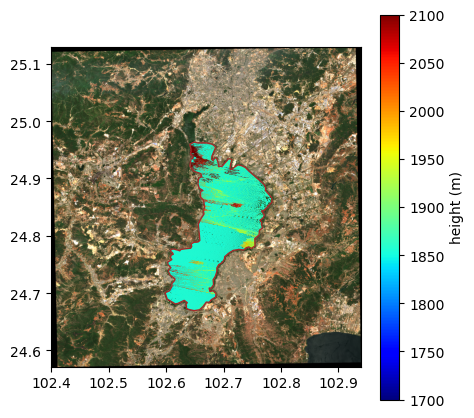

In [5]:
## ax 0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
scat = ax.scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
              s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=1)
show(rsimg_rio, ax=ax, indexes=[3,2,1], percent_range=[2,98])
fig.colorbar(scat).set_label('height (m)')


#### （2）geophysical correction

In [6]:
heights_cor = pixc_geophy_cor(pixc_nc=pixc_nc)
heights_cor = heights_cor - pixc_nc.geoid.values   ## to egm2008 height


#### (3) Outlier removing using IQR method.

In [7]:
heights_cor_IQR, IQR = IQR_filter(heights_cor)
print(IQR)
iter = 0
while IQR > 0.5:    
    iter += 1
    heights_cor_IQR_mask = heights_cor_IQR.mask
    heights_cor_IQR, IQR = IQR_filter(heights_cor_IQR.filled(np.nan))
    heights_cor_IQR.mask = heights_cor_IQR.mask | heights_cor_IQR_mask
    if iter == 3: break   ## max iteration: 4 times.
print(IQR)


65.550048828125
0.282470703125


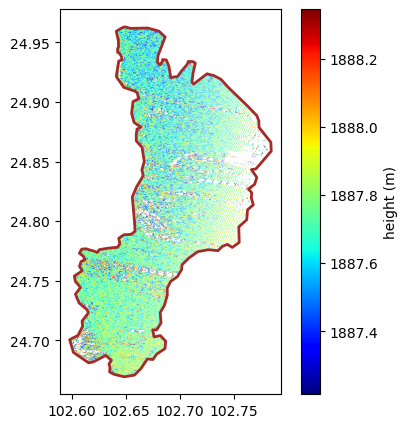

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
scat = ax.scatter(x=pixc_nc.longitude[~heights_cor_IQR.mask], y=pixc_nc.latitude[~heights_cor_IQR.mask], \
                  c=heights_cor[~heights_cor_IQR.mask], s=0.1, edgecolor='none', cmap='jet')
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
fig.colorbar(scat).set_label('height (m)')


#### (4) Lake level extraction (the mean and std values of the heights)  

In [9]:
### area weighting heights
def area_averaged(heights, areas):
  pixel_heights_sum = np.sum(areas*heights)
  pixel_AreaWeighted_height = pixel_heights_sum/np.sum(areas)
  weighted_var = [(heights[i] - pixel_AreaWeighted_height)**2*areas[i] for i in range(heights.shape[0])]
  weighted_var_sum = np.sum(weighted_var)
  weighted_std = np.sqrt(weighted_var_sum/sum(areas))
  return pixel_AreaWeighted_height, weighted_std

pixel_area = pixc_nc.pixel_area.values
pixel_height_IQR_masked = heights_cor[~heights_cor_IQR.mask]
pixel_area_IQR_masked = pixel_area[~heights_cor_IQR.mask]
pixel_height_area_weighted, std_area_weighted = area_averaged(heights=pixel_height_IQR_masked, areas=pixel_area_IQR_masked)
print('Average height:', np.mean(pixel_height_IQR_masked))
print('Area Weighted average height:', pixel_height_area_weighted)
print('Standard deviation of height: ', np.std(pixel_height_IQR_masked))
print('Area Weighted standard deviation: ', std_area_weighted)



Average height: 1887.7202
Area Weighted average height: 1887.7277
Standard deviation of height:  0.1568616
Area Weighted standard deviation:  0.15696927871337588


#### Combined tha above steps for time-series water level extraction

In [10]:
## get acquisition time 
dates_data = [path.split('_')[-4] for path in paths_file]
dates_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8]+'T'+date[9:11]+':'+date[11:13]+':'+date[13:15]
              for date in dates_data]
## convert date to decimal
dates_decimal = [dt64_to_dyr(date) for date in dates_data]
dates_decimal = [round(date, 5) for date in dates_decimal]
dates_decimal[2]


2024.18306

In [11]:
wse_lake_mean_std = {'date': [], 'mean': [], 'std': []}
for i, path in enumerate(paths_file):
  print(i, path)
  date_decimal = dates_decimal[i]
  ## (1) data reading
  pixc_nc = xr.open_dataset(path)
  ## (2) geophysical corrections and convert to egm2008 height.
  heights_cor = pixc_geophy_cor(pixc_nc=pixc_nc)
  heights_cor =  heights_cor - pixc_nc.geoid.values  ## to egm2008 height  
  ## (3) outliers removing using IQR method.
  iter = 0
  heights_cor_IQR, IQR = IQR_filter(heights_cor)
  while IQR > 0.5:    
      iter += 1
      heights_cor_IQR_mask = heights_cor_IQR.mask
      heights_cor_IQR, IQR = IQR_filter(heights_cor_IQR.filled(np.nan))
      heights_cor_IQR.mask = heights_cor_IQR.mask | heights_cor_IQR_mask
      if iter == 2: break   ## max iteration: 4 times.
  if IQR > 0.5: continue
  if (~heights_cor_IQR.mask).sum() < 50: continue  ## the threshold of the number of valid measurements. 
  ## (4) lake level calculation (area weighted average and std of the heights).
  pixel_area = pixc_nc.pixel_area.values
  pixel_heights_IQR_masked = heights_cor_IQR[~heights_cor_IQR.mask]
  pixel_area_IQR_masked = pixel_area[~heights_cor_IQR.mask]
  pixel_height_area_weighted, std_area_weighted = area_averaged(heights=pixel_heights_IQR_masked, areas=pixel_area_IQR_masked)
  wse_lake_mean_std['date'].append(date_decimal)
  wse_lake_mean_std['mean'].append(pixel_height_area_weighted)
  wse_lake_mean_std['std'].append(std_area_weighted)



0 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PIC0_01_masked.nc
1 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_010_049_198L_20240126T180154_20240126T180205_PIC0_01_masked.nc
2 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_012_049_198L_20240308T113203_20240308T113214_PIC0_01_masked.nc
3 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_014_049_198L_20240419T050213_20240419T050224_PIC0_01_masked.nc
4 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_016_049_198L_20240530T223221_20240530T223232_PIC0_01_masked.nc
5 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_018_049_198L_20240711T160229_20240711T160240_PIC0_01_masked.nc
6 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_019_049_198L_20240801T124734_20240801T124745_PIC0_02_masked.nc
7 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_021_049_198L_20240912T061744_20240912T061755_PIC0_01_masked.nc
8 data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_025_049_198L_20241204T171804_20241204T171816_PIC2_01_masked.nc


In [ ]:
# ## save results
wse_lake_mean_std_df = pd.DataFrame(wse_lake_mean_std)
# wse_lake_mean_std_df.to_csv('data/result/pixc_dianchi_wse.csv', index=False)
print(wse_lake_mean_std_df)


         date         mean       std
0  2024.01093  1887.702637  0.117653
1  2024.06831  1887.727661  0.156969
2  2024.18306  1887.742676  0.187102
3  2024.29781  1887.595093  0.174104
4  2024.40984  1887.450317  0.181388
5  2024.52459  1887.579346  0.147380
6  2024.58197  1887.641357  0.175818
7  2024.69672  1887.803223  0.120522
8  2024.92350  1887.810181  0.162158


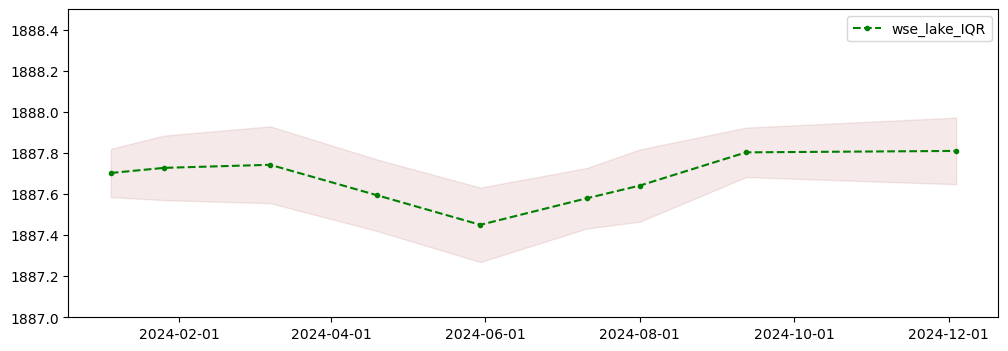

In [13]:
dates_ticks = ['2024-'+str(i+1).zfill(2)+'-01'  for i in range(1,12,2)]
dates_ticks_dyr = [dt64_to_dyr(date) for date in dates_ticks]
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(wse_lake_mean_std['date'], wse_lake_mean_std['mean'], '--.', color='green', label='wse_lake_IQR')
ax.fill_between(wse_lake_mean_std['date'], np.array(wse_lake_mean_std['mean']) - np.array(wse_lake_mean_std['std']), \
                np.array(wse_lake_mean_std['mean']) + np.array(wse_lake_mean_std['std']), color='Brown', alpha=0.1)
ax.set_ylim([1887, 1888.5])
ax.set_xticks(dates_ticks_dyr)
ax.set_xticklabels(dates_ticks)
ax.legend()
